#### Example getting, prepping and working with SDO/AIA data
Here using [sunpy](https://sunpy.org/) and [aiapy](https://pypi.org/project/aiapy/) with the other usual python packages. Working with the event featured in [Hannah & Kontar 2013 A&A](https://doi.org/10.1051/0004-6361/201219727).

* 21-Jan-2022 IGH
* 24-Jan-2022 - Tweaked plot and comments
* 28-Jan-2022 - Added in another timeseries plotting method
* 08-Feb-2022 - Tweaked timeseries plotting and saveout
* 11-Feb-2002 - Made loading/prep of full images less memory intensive

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
import glob
import gc

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
fdir='/Users/iain/Desktop/aia_data/' 

---

In [3]:
# # Can either get the example data via fido/vso or adapt the example to your own AIA data set
# from sunpy.net import Fido, attrs as a

# # In this example only getting 94A (obviously for DEM calc would need more channels)
# wvsrch=a.Wavelength(94*u.angstrom)

# result = Fido.search(a.Time('2010-11-03T12:13:00', '2010-11-03T12:17:00'), a.Instrument("aia"), wvsrch)
# files = Fido.fetch(result,path='/Users/iain/Desktop/aia_data/')

In [4]:
# # Load in our AIA files for prep
# ff=sorted(glob.glob(fdir+'aia_lev1_94a_*.fits'))
# print(ff)

In [5]:
# # In previous version just loaded all ff into single map, i.e amaps=sunpy.map.Map(ff)
# # but if a lot of images your machine might not be able to handle them so 
# # instead here we will loop over the individually, prep, submap and save out

# for fname in ff:
#     print(fname)
# #   prep the data using aiapy
#     a_temp=sunpy.map.Map(fname)
#     m_temp = update_pointing(a_temp)
#     p_temp=register(m_temp)
    
# #   Don't need full map so submap and save out
# #   ideally submap to a bit bigger than you need, as can always submap again
#     blo=[-1150*u.arcsec,-500*u.arcsec]
#     tro=[-850*u.arcsec,-200*u.arcsec]
#     bottom_left = SkyCoord(blo[0],blo[1], frame=p_temp.coordinate_frame)
#     top_right = SkyCoord(tro[0],tro[1], frame=p_temp.coordinate_frame)
#     s_temp=p_temp.submap(bottom_left=bottom_left, top_right=top_right)
# #   name file based on   
#     dname=p_temp.meta["date-obs"]
#     wvname=str(p_temp.meta["wavelnth"])
#     fname='aia_sub_'+wvname+"_"+\
#          dname[0:4]+dname[5:7]+dname[8:10]+'_'+dname[11:13]+dname[14:16]+dname[17:19]+'.fits'
#     print(fname)
#     s_temp.save(fdir+fname,overwrite='True')
    
# #   Probably don't need the next two lines but just to be safe  
#     del s_temp,p_temp,m_temp,a_temp
#     gc.collect()


---

In [6]:
# If you have run the above cell once then can just load the submaps back in 
# and don't have to get and prep the data
ffin=sorted(glob.glob(fdir+'aia_sub_94_*.fits'))
# nfls=len(ffin)
# print(ffin)
aprep=sunpy.map.Map(ffin)

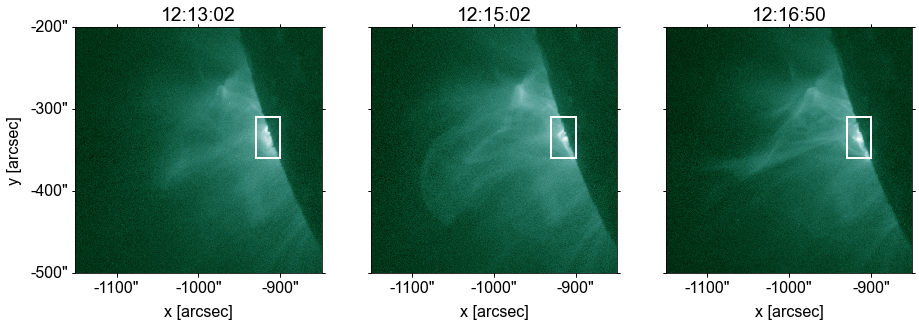

In [7]:
# check to see what they look like and pick region for more analysis

bbl=[-930 * u.arcsec, -360 * u.arcsec]
btr=[-900 * u.arcsec, -310 * u.arcsec]

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=aprep[0])
aprep[0].plot(axes=ax1)
ax1.set_xlabel("x [arcsec]")
ax1.set_ylabel("y [arcsec]")
ax1.set_title(aprep[0].meta["date-obs"][11:19])
ax1.grid(False)
aprep[0].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[0].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[0].coordinate_frame),\
                         edgecolor="white",lw=2)

ax2 = fig.add_subplot(1, 3, 2, projection=aprep[10])
aprep[10].plot(axes=ax2)
ax2.set_xlabel("x [arcsec]")
ax2.set_ylabel(" ")
tx, ty = ax2.coords
ty.set_ticklabel_visible(False)
ax2.set_title(aprep[10].meta["date-obs"][11:19])
ax2.grid(False)
aprep[10].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[10].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[10].coordinate_frame),\
                         edgecolor="white",lw=2)

ax3 = fig.add_subplot(1, 3, 3, projection=aprep[19])
aprep[19].plot(axes=ax3)
ax3.set_xlabel("x [arcsec]")
ax3.set_ylabel(" ")
tx, ty = ax3.coords
ty.set_ticklabel_visible(False)
ax3.set_title(aprep[19].meta["date-obs"][11:19])
ax3.grid(False)
aprep[19].draw_quadrangle(SkyCoord(bbl[0],bbl[1], frame=aprep[19].coordinate_frame),\
                         top_right=SkyCoord(btr[0],btr[1], frame=aprep[19].coordinate_frame),\
                         edgecolor="white",lw=2)
plt.show()

In [8]:
# Let's loop over the new subregion to find the mean DN/px
# Then divide by duration to get DN/px/s
data=[]
bbl=[-930 * u.arcsec, -360 * u.arcsec]
btr=[-900 * u.arcsec, -310 * u.arcsec]
for m in aprep:
    bottom_left = SkyCoord(bbl[0],bbl[1], frame=m.coordinate_frame)
    top_right = SkyCoord(btr[0],btr[1], frame=m.coordinate_frame)
    mm = m.submap(bottom_left=bottom_left, top_right=top_right)
    data.append(np.mean(m.data)/m.meta["exptime"])
data=np.array(data)
print(data)

[5.40725629 5.41523199 5.38494472 5.42639206 5.5236923  5.61216869
 5.71286588 5.76869824 5.82325456 5.84254283 5.85396775 5.87007449
 5.90474606 5.93177638 5.95707058 5.96855039 5.99908338 6.01672211
 6.04993912 6.07054868]


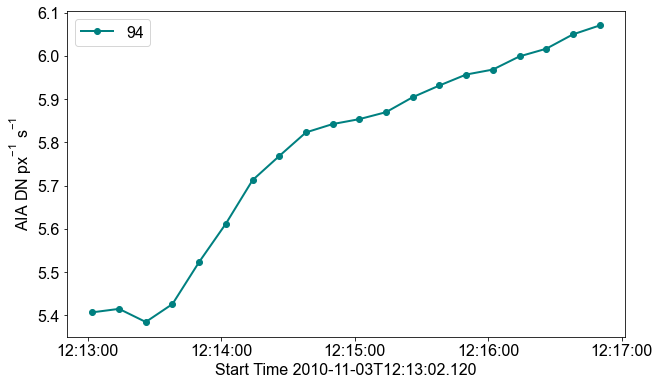

In [9]:
# Many ways of plotting data vs time in python (pandas, sunpy timeseries etc) here just using
# datetime with matplotlib
times=[m.date.datetime for m in aprep]
fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(times,data,label="94",lw=2,color='teal',marker='o')
ax.set_xlabel('Start Time '+aprep[0].date.isot)
ax.set_ylabel('AIA DN px$^{-1}$ s$^{-1}$')
# Need to tweak time labelling on the x-axis
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
# majorx= matplotlib.dates.SecondLocator(interval=45)
majorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_major_formatter(myFmt)
plt.legend()
plt.show()

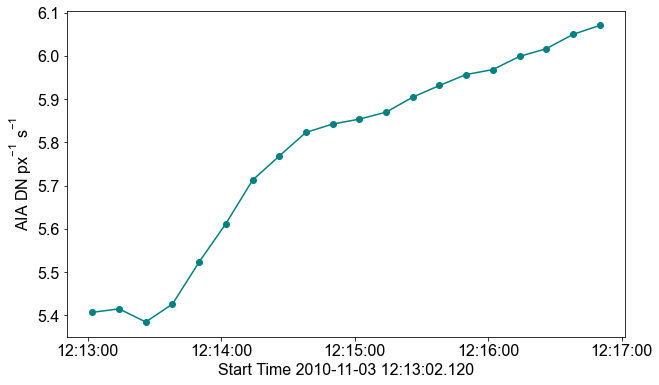

In [10]:
# Could also do this via pandas dataframe as gives lots of options
import pandas as pd
df = pd.DataFrame(data, index=times, columns=['dnpxs94'])
# Save to csv file
df.to_csv('ltc_test.csv')

# If previously saved out can reload back in 
df2=pd.read_csv('ltc_test.csv', index_col=0, parse_dates=True)

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(df2.index,df2["dnpxs94"].values,marker='o',color='teal')
ax.set_xlabel('Start Time '+df2.index.astype(str)[0])
ax.set_ylabel('AIA DN px$^{-1}$ s$^{-1}$')
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_major_formatter(myFmt)
plt.show()

In [11]:
# # Could also do it via astropy timeseries
# # Careful as this timeseries different from the sunpy one used above
# from astropy.timeseries import TimeSeries

# ltc=TimeSeries(time=[m.date.isot for m in aprep],\
#                data={'dnpxs': data})

# # # Means that it is easy to save out the data, and load back in, i.e
# # ltc.write('aia_ltc.txt',format='ascii.csv',overwrite=True)
# # ltcn=TimeSeries.read('aia_ltc.txt',format='ascii.csv',time_column='time',time_format='isot')

# plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
#                      'font.sans-serif':"Arial",'mathtext.default':"regular"})
# fig,ax= plt.subplots(figsize=(10, 6))
# plt.plot_date(ltc.time.datetime, ltc['dnpxs'],marker='o',ls='solid',color='teal')
# plt.ylabel('AIA DN px$^{-1}$ s$^{-1}$')
# plt.xlabel('Start Time '+ltc.time[0].iso[:-4])
# majorx= matplotlib.dates.MinuteLocator(interval=1)
# ax.xaxis.set_major_locator(majorx)
# ax.xaxis.set_major_formatter(myFmt)
# fig.show()